# This is codes for *midterm report* of `Deep Learning` class in Fall 2024.

Author: Nur Rahmawati Ayukaryana

Affiliation: Yamamoto Lab, Department of Biomedical Engineering

Instructor: Prof. Yasuhiro Takaki

# Gaussian Distribution (One Dimensional)

I will start by introducing mean and standard deviation concept in normal distribution.

I try to recreate the typical student moods during progress report meeting, party, and weekend.

In [25]:
#Importing the libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

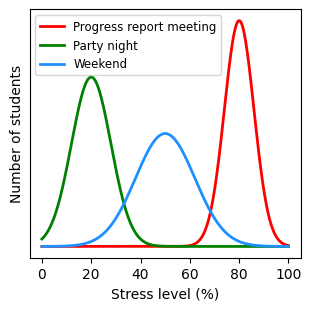

In [26]:
fig, ax = plt.subplots(figsize=(3,3), layout='constrained')

def normal(x, mu=0, sigma=1):
    y = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y

x = np.linspace(0, 100, 1000)

#Assuming mean and standard distribution are what I typically observed
y0 = normal(x, mu=50, sigma=12) #weekend moods typically mildly stressed, but there are some students on the stressed mode if they go to the lab during weekend
y1 = normal(x, mu=80, sigma=6) #most students are stressed during progress report meeting
y2 = normal(x, mu=20, sigma=8) #during party, stress level is hugely shifted for most students, becoming super duper chill
#The assumption won't work if students love what they do at the lab, author is an outlier.

ax.plot(x, y1, label='Progress report meeting', color='red',linewidth=2)
ax.plot(x, y2, label='Party night', color='green',linewidth=2)
ax.plot(x, y0, label='Weekend', color='dodgerblue',linewidth=2)

ax.legend(loc='best',fontsize=8.5)
ax.set_xlabel('Stress level (%)')
ax.set_ylabel('Number of students')
ax.tick_params(axis='y', left=False, right=False, labelleft=False)

fig.savefig('plot1', transparent=True)

# The Central Limit Theorem

Next, I want to introduce the Central Limit Theorem as the major reason of how important Gaussian distribution is.

I divide a group of students to fall into into "calm" and "stressed" category.

In [27]:
#Generate random data
#Assuming that calm and stressed students fall under the category of mean and standard deviation below
np.random.seed(42)
calm = np.random.normal(loc=20, scale=10, size=100)
stressed = np.random.normal(loc=80, scale=15, size=100)
bimodal = np.concatenate([calm, stressed]) #create bimodal distribution from the calm and stressed category

#Group averages by the Central Limit Theorem
means = []
group_size = 80
num_groups = 1000

for _ in range(num_groups):
    sample = np.random.choice(bimodal, size=group_size, replace=False)
    means.append(np.mean(sample))

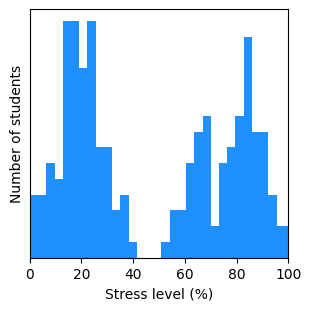

In [28]:
#Plotting the generated random data
fig, ax = plt.subplots(figsize=(3,3), layout='constrained')
ax.hist(bimodal, bins=40, color="dodgerblue")

ax.set_ylabel("Number of students")
ax.set_xlabel("Stress level (%)")
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.set_xlim(0,100)

fig.savefig('plot2', transparent=True)

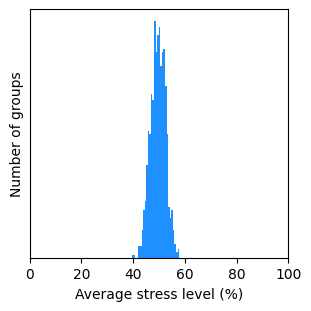

In [29]:
#Plotting the proof of the Central Limit Theorem
fig, ax = plt.subplots(figsize=(3,3), layout='constrained')
ax.hist(means, bins=30, color="dodgerblue")

ax.set_ylabel("Number of groups")
ax.set_xlabel("Average stress level (%)")
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax.set_xlim(0,100)

fig.savefig('plot3', transparent=True)

Well, on average, students are moderately stressed, it is normally distributed, just like the theory stated.

# Gaussian Mixture Model

Here, I want to introduce two Gaussian distributions of "calm" and "stressed" students with two variables (snack consumption and stress level).

This data was inspired by my own stress-eating behavior.

In [30]:
#Assume GMM parameters as I prefer
mus = np.array([[25, 3],  # Mean stress and snacks for calm students
                [75, 7]])  # Mean stress and snacks for stressed students
covs = np.array([[[33, 1],
                  [1, 0.5]],  # Covariance for calm students
                [[77, 2],
                  [2, 0.8]]])  # Covariance for stressed students
phis = np.array([0.4, 0.6])  # Proportions of calm and stressed students

#Define functions
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm_density(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

#Create a grid for stress levels (X) and snacks/day (Y)
stress_levels = np.linspace(0, 100, 100)
snacks_per_day = np.linspace(0, 10, 100)
X, Y = np.meshgrid(stress_levels, snacks_per_day)

#Compute GMM density (Z)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = gmm_density(np.array([X[i, j], Y[i, j]]), phis, mus, covs)

#Generate random data
np.random.seed(42)
N = 500
XY = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(2, p=phis)
    mu, cov = mus[k], covs[k]
    XY[n] = np.random.multivariate_normal(mu, cov)

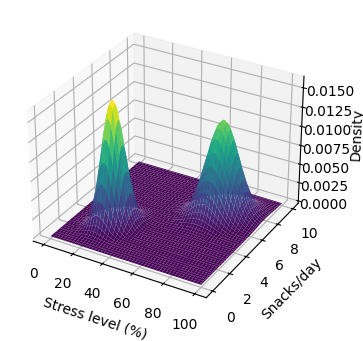

In [31]:
#Plot probability density in 3D surface plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("Stress level (%)")
ax.set_ylabel("Snacks/day")
ax.set_zlabel("Density")
ax.plot_surface(X, Y, Z, cmap='viridis')

fig.savefig('plot4', transparent=True)

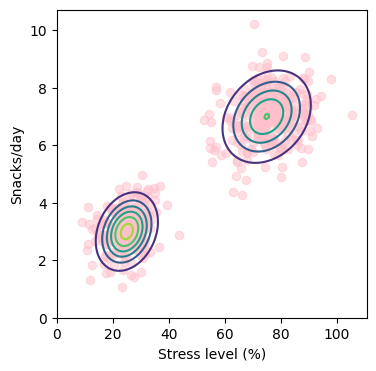

In [32]:
#Plot probability density in 2D contour plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlabel("Stress level (%)")
ax.set_ylabel("Snacks/day")
ax.contour(X, Y, Z)
ax.scatter(XY[:,0], XY[:,1], alpha=0.5, color='pink')

fig.savefig('plot5', transparent=True)

# Implementation of EM Algorithm

## Random Data Generation with Noise

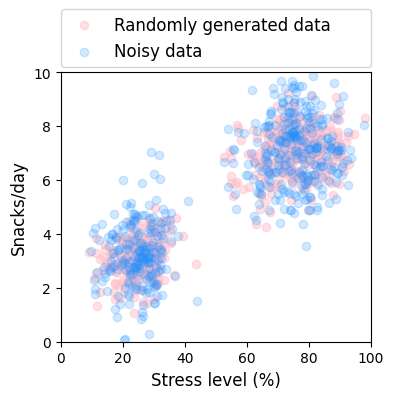

In [33]:
#Assume parameters as preferred (similar to previous GMM example)
true_phis = np.array([0.4, 0.6])
true_mus = np.array([[25, 3],
                    [75, 7]])
true_covs = np.array([[[33, 1],
                       [1, 0.5]],
                      [[77, 2],
                       [2, 0.8]]])

#Generate data based on assumed parameters
np.random.seed(42) #recreate the similar random data as the previous plot
N = 500
XY = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(len(true_phis), p=true_phis)
    XY[n] = np.random.multivariate_normal(true_mus[k], true_covs[k])

#Add Gaussian noise to the generated data
noise = np.random.normal(0, 1, XY.shape)
noisy_data = XY + noise

#Visualize noisy data
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.set_xlabel("Stress level (%)",fontsize=12)
ax.set_ylabel("Snacks/day",fontsize=12)
ax.scatter(XY[:,0], XY[:,1], alpha=0.5, c='pink', label='Randomly generated data')
ax.scatter(noisy_data[:,0], noisy_data[:,1], alpha=0.2, c='dodgerblue', label='Noisy data')
ax.set_xlim(0,100)
ax.set_ylim(0,10)
ax.legend(fontsize='12', numpoints=1, bbox_to_anchor=(0., 1.02, 1., .102),
                      ncols=1, mode="expand", borderaxespad=0.)

fig.savefig('plot6', transparent=True)

## Parameter Estimation with EM Algorithm

In [34]:
#Initialize parameters as a guess
phis = np.array([0.5, 0.5])
mus = np.array([[20, 5],
                [80, 5]])
covs = np.array([np.eye(2),
                 np.eye(2)])  #Use identity matrices as initial covariances

K = len(phis)
N = len(noisy_data)
MAX_ITERS = 100
THRESHOLD = 1e-4

def likelihood(xs, phis, mus, covs):
    eps = 1e-8
    L = 0
    for x in xs:
        y = gmm_density(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / len(xs)

current_likelihood = likelihood(noisy_data, phis, mus, covs)

for iter in range(MAX_ITERS):
    #E-step
    qs = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            qs[n, k] = phis[k] * multivariate_normal(noisy_data[n], mus[k], covs[k])
        qs[n] /= gmm_density(noisy_data[n], phis, mus, covs)

    #M-step
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        phis[k] = qs_sum[k] / N
        mus[k] = np.sum(qs[:, k, None] * noisy_data, axis=0) / qs_sum[k]
        covs[k] = sum(qs[n, k] * np.outer(noisy_data[n] - mus[k], noisy_data[n] - mus[k]) for n in range(N)) / qs_sum[k]

    #Threshold check
    print(f'{current_likelihood:.3f}')

    #Check convergence
    next_likelihood = likelihood(noisy_data, phis, mus, covs)
    if np.abs(next_likelihood - current_likelihood) < THRESHOLD:
        break
    current_likelihood = next_likelihood

#Print estimated parameters
print("========================")
print("Estimated means:")
print(mus)
print("\nEstimated covariances:")
print(covs)
print("\nEstimated categorial distributions:")
print(phis)

#Print difference between original parameters and estimated parameters
print("========================")
print("Difference in means:")
print(true_mus-mus)
print("\nDifference in covariances:")
print(true_covs-covs)
print("\nDifference in categorial distributions:")
print(true_phis-phis)

-14.752
-5.746
Estimated means:
[[24  3]
 [75  7]]

Estimated covariances:
[[[38.34400652  1.19076995]
  [ 1.19076995  1.39540568]]

 [[77.22143926  0.52737544]
  [ 0.52737544  1.61010045]]]

Estimated categorial distributions:
[0.41793843 0.58206157]
Difference in means:
[[1 0]
 [0 0]]

Difference in covariances:
[[[-5.34400652 -0.19076995]
  [-0.19076995 -0.89540568]]

 [[-0.22143926  1.47262456]
  [ 1.47262456 -0.81010045]]]

Difference in categorial distributions:
[-0.01793843  0.01793843]


## Data Generation with Estimated Parameters from EM Algorithm

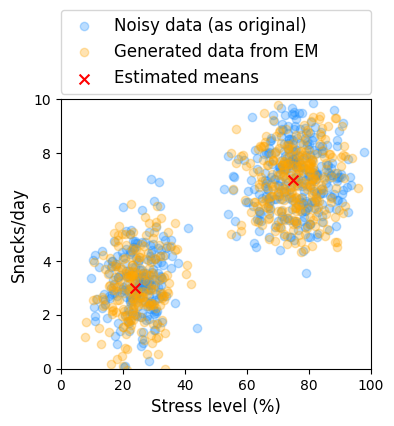

In [35]:
#Generate new data based on estimated parameters
new_XY = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(K, p=phis)
    new_XY[n] = np.random.multivariate_normal(mus[k], covs[k])

#Visualize original noisy data and generated data
fig, ax = plt.subplots(figsize=(4, 3.5))

ax.scatter(noisy_data[:, 0], noisy_data[:, 1], c='dodgerblue', alpha=0.3, label='Noisy data (as original)')
ax.scatter(new_XY[:, 0], new_XY[:, 1], c='orange', alpha=0.3, label='Generated data from EM')
ax.scatter(mus[:, 0], mus[:, 1], c='red', marker='x', s=50, label='Estimated means')
ax.set_xlabel("Stress level (%)",fontsize=12)
ax.set_ylabel("Snacks/day",fontsize=12)
ax.set_xlim(0,100)
ax.set_ylim(0,10)
#ax.legend(loc='upper left',fontsize=12)
ax.legend(fontsize='12', numpoints=1, bbox_to_anchor=(0., 1.02, 1., .102),
                      ncols=1, mode="expand", borderaxespad=0.)

fig.savefig('plot7', transparent=True)

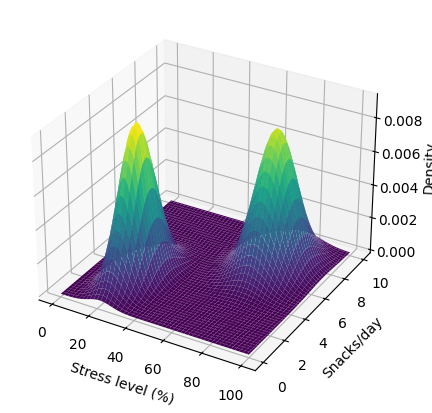

In [36]:
#Create a grid for stress levels (new_X) and snacks/day (new_Y)
stress_levels = np.linspace(0, 100, 100)
snacks_per_day = np.linspace(0, 10, 100)
new_X, new_Y = np.meshgrid(stress_levels, snacks_per_day)

#Compute GMM density (Z)
new_Z = np.zeros_like(new_X)
for i in range(new_X.shape[0]):
    for j in range(new_X.shape[1]):
        new_Z[i, j] = gmm_density(np.array([new_X[i, j], new_Y[i, j]]), phis, mus, covs)

#3d visualization of the newly generated data
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("Stress level (%)")
ax.set_ylabel("Snacks/day")
ax.set_zlabel("Density")
#ax.set_title('Generated data from EM')
ax.plot_surface(new_X, new_Y, new_Z, cmap='viridis')

fig.savefig('plot8', transparent=True)